# Learning Analytics - Multiple Linear Regression

Data Source: https://www.kaggle.com/rocki37/open-university-learning-analytics-dataset  
Data description: https://analyse.kmi.open.ac.uk/open_dataset#description

The data, from Open University, covers student assessment and VLE interaction for 28785 students. 

In this investigation, I am looking at whether student demographic data, as well as interaction with the VLE can be a predictor of assessment scores by module. 

### Initial Question: 
Can we use what we know about students, and their engagement on the VLE to predict assessment outcomes?  

We will use:  
1. Mean number of clicks per module  
2. Mean score on assessments per module

This will smooth the data somewhat, so it won't be possible to tell if somebody engages significantly more before one specific assessment, but unfortunately the StudentVLE table only includes the sum of clicks on the VLE by module. 

Database Schema:
<img src="files/model.png">

## Loading, joining and cleaning the Data

We need the following two tables in order to get student assessment results for each assessment and by module:
1. Assessments
2. Student Assessments

We then have two more tables to give us student demographics and clicks on the VLE by module:
3. Student Info
4. Student VLE

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

#load tables
assessments = pd.read_csv('assessments.csv')
student_assessment = pd.read_csv('studentAssessment.csv')
student_info = pd.read_csv('studentInfo.csv')
vle_activity = pd.read_csv('studentVLE.csv')

#From the assessments table, we only need code_module so that we can get assessment information by
#module
assessments.drop(['code_presentation','assessment_type','date','weight'], axis = 1, inplace = True)
assessment_count = assessments.code_module.value_counts()

print('Number of assessments in each module:',assessment_count)

Number of assessments in each module: FFF    52
BBB    42
DDD    35
GGG    30
CCC    20
EEE    15
AAA    12
Name: code_module, dtype: int64


In [102]:
#merge student assessment and assessment tables, so that we know which module each assessment belongs to
comb_assess = pd.merge(student_assessment,assessments,on='id_assessment')
comb_assess.drop(['is_banked','date_submitted'],axis = 1,inplace=True)
comb_assess.dtypes

id_assessment     int64
id_student        int64
score            object
code_module      object
dtype: object

In [103]:
#clean some of the data - score is currently an object, we want it as an integer. So let's remove the ?
comb_assess.drop(comb_assess[comb_assess.score == '?'].index, inplace = True);
comb_assess.score = comb_assess.score.astype(int);
comb_assess.dtypes

id_assessment     int64
id_student        int64
score             int64
code_module      object
dtype: object

In [104]:
#how much data do we have?
rows = comb_assess.shape[0];
print(f'There are {rows} individual assessment scores in the dataset.')

There are 173739 individual assessment scores in the dataset.


In [105]:
#group by student and then subgroup by module, so that we retain ability to evaluate different module predictability
#we choose to take the mean assessment score by module. 
grouped = comb_assess.groupby(['id_student','code_module']).mean()
grouped.sort_values('id_student')

#we can't keep id_assessment, because we have just grouped by module. We have to group by module, 
#as our vle interaction data is only grouped by module
grouped.drop(['id_assessment'],axis=1,inplace = True)
grouped.head()

score
id_student code_module           
6516       AAA          61.800000
8462       DDD          87.000000
11391      AAA          82.000000
23629      BBB          82.500000
23698      CCC          74.444444

In [106]:
num_of_students = len(student_info.id_student.unique())
print(f'There are {num_of_students} students in the dataset')

There are 28785 students in the dataset


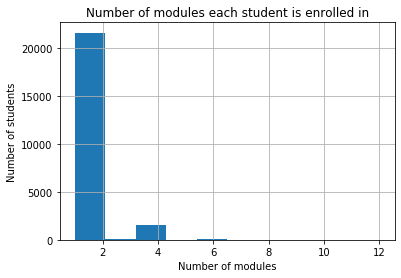

In [107]:
#merge demographic data
student_all_info = pd.merge(student_info,grouped,on='id_student')

#just getting a feel for it - how many modules is each student enrolled in?
fig1 = student_all_info.groupby(['id_student']).code_module.count().sort_values().hist();
plt.xlabel('Number of modules');
plt.ylabel('Number of students');
plt.title('Number of modules each student is enrolled in');

In [108]:
#total number of clicks per student by module
vle_grouped = vle_activity.groupby(['id_student','code_module']).sum()
#we have to drop the columns below as we have grouped by student and subgrouped by module, so they are meaningless
vle_grouped.drop(['id_site','date'],axis=1,inplace=True)
vle_grouped.head()

sum_click
id_student code_module           
6516       AAA               2791
8462       DDD                656
11391      AAA                934
23629      BBB                161
23698      CCC                910

In [109]:
#left join as we want to keep student info where no clicks were made
df = pd.merge(student_all_info,vle_grouped,on = ['id_student','code_module'],how='left')

In [110]:
#remove rows where there are null values for sum_click. There are only 201 so it won't have a huge impact
df.dropna(inplace=True)

In [111]:
#save the new table
df.to_csv('joinedData.csv',index=False)

In [112]:
df.dtypes

#this shows we need to create categorical variables

code_module              object
code_presentation        object
id_student                int64
gender                   object
region                   object
highest_education        object
imd_band                 object
age_band                 object
num_of_prev_attempts      int64
studied_credits           int64
disability               object
final_result             object
score                   float64
sum_click               float64
dtype: object

In [113]:
df.code_module = pd.Categorical(df.code_module)
df.code_presentation = pd.Categorical(df.code_presentation)
df.gender = pd.Categorical(df.gender)
df.region = pd.Categorical(df.region)
df.highest_education = pd.Categorical(df.highest_education)
df.imd_band = pd.Categorical(df.imd_band)
df.age_band = pd.Categorical(df.age_band)
df.disability = pd.Categorical(df.disability)
df.final_result = pd.Categorical(df.final_result)

So we now have a dataframe with student info, average assessment score for that module and average number of clicks for that module. We will now inspect the data for missing data, and ensure it's clean. 

## Initial exploration of the data

In [114]:
df.head()

code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       31604      F     South East Region   
3         AAA             2013J       32885      F  West Midlands Region   
4         AAA             2013J       38053      M                 Wales   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   50-60%    35-55                     0   
3     Lower Than A Level   50-60%     0-35                     0   
4  A Level or Equivalent   80-90%    35-55                     0   

   studied_credits disability final_result  score  sum_click  
0              240          N         Pass   82.0      934.0  
1               60          N         Pass   66.4     1435.0  
2               60          N         Pass   76.0     2158.0  
3               60          N         Pass   54.4     1034.0  
4               60          N         Pass   68.0     2445.0

In [115]:
import plotly.express as px
data = df
fig = px.box(data, x="code_module", y="score",title='Student average scores by Module')

fig.show()

In [116]:
data = df
fig = px.box(data, x="region", y="score",title='Student average scores by Region')

fig.show()

### What this tells us:
1. All modules have a lower tail, and 6 out of 7 have zero scores included  
2. Scores by region are fairly consistent  

Next we will look at highest education level.

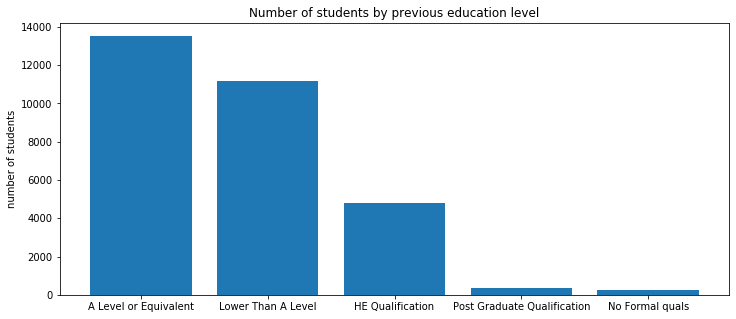

In [117]:
highest_ed = df.highest_education.value_counts();
f, ax = plt.subplots(figsize=(12,5));
ax.bar(highest_ed.index,highest_ed);
plt.ylabel('number of students');
plt.title('Number of students by previous education level')
df.highest_education.cat.categories;

### What this tells us:
We need to be careful about generalising for the two categories Post Grad and No prior quals as they only have small numbers  

And below, we can see there isn't much variation by gender

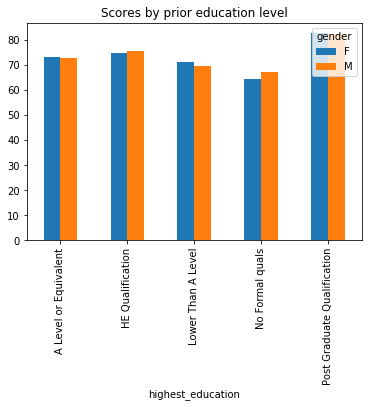

In [118]:
for_bar = df.pivot_table(index = 'highest_education', columns='gender', values = 'score');
for_bar.plot(kind='bar');
plt.title('Scores by prior education level');

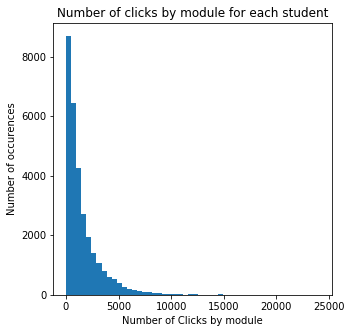

In [119]:
# how many times do students click on the vle?
interaction_by_module = df.sum_click
fig2, ax2 = plt.subplots(figsize=(5,5));
ax2.hist(interaction_by_module,bins=50);
ax2.set_xlabel('Number of Clicks by module');
ax2.set_title('Number of clicks by module for each student');
ax2.set_ylabel('Number of occurences');


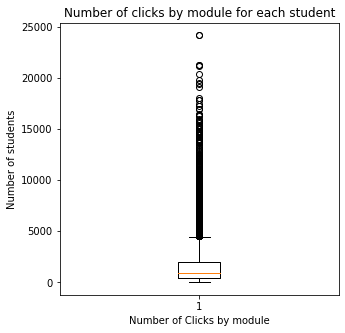

In [120]:
interaction_by_module = df.sum_click
fig2, ax2 = plt.subplots(figsize=(5,5));
ax2.boxplot(interaction_by_module);
ax2.set_xlabel('Number of Clicks by module');
ax2.set_title('Number of clicks by module for each student');
ax2.set_ylabel('Number of students');

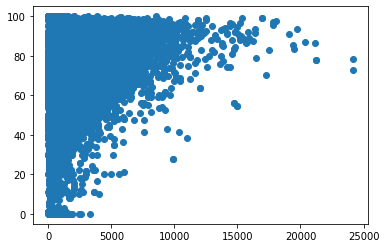

In [121]:
plt.scatter((df.sum_click),(df.score))

### What this shows us
Most students perform under 1000 clicks per module. There is a long tail of keen students though!  
There isn't a clear linear relationship between number of clicks and average assessment score by module

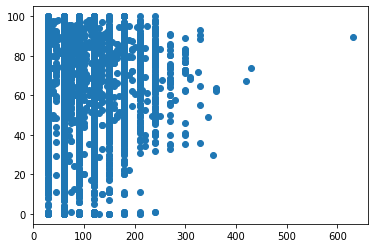

In [122]:
plt.scatter((df.studied_credits),(df.score));

### What this shows us
We should put the studied_credits data in bins, as it would make more sense as categorical data - it only appears as certain value.

In [123]:
bins = [0,50,100,150,200,250,300,350,400,450,500,550,600]
df['studied_credits'] = pd.cut(df['studied_credits'], bins=bins)

In [124]:
df2 = df.groupby(['gender','code_module']).score.mean()

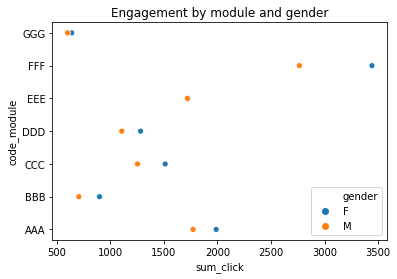

In [125]:
import seaborn as sns

df3 = df.groupby(['gender','code_module']).sum_click.mean()
codes =  df2.index.get_level_values(1)
codes
sns.scatterplot(df3,df3.index.get_level_values(1), hue = df2.index.get_level_values(0), legend='full');
plt.title('Engagement by module and gender');

### What this shows us
Women tend to be more engaged with the VLE. This is the case in 6 out of 7 modules.

### Question: Does this higher engagement for women translate to better scores? 

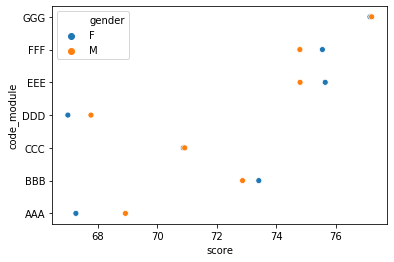

In [126]:
codes =  df2.index.get_level_values(1)
codes
sns.scatterplot(df2,df2.index.get_level_values(1), hue = df2.index.get_level_values(0), legend='full');

### What this shows us
There aren't huge differences in performance by gender for each module

## Does the total number of clicks impact the final result?

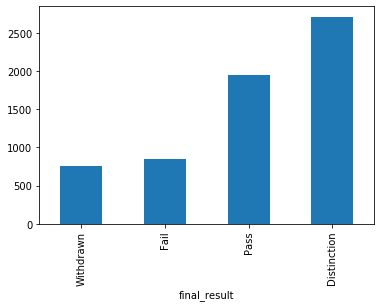

In [127]:
df.groupby('final_result').sum_click.mean().sort_values().plot(kind='bar');

So there does seem to be some pattern between final score and engagement on the vle

Let's look at the range now

In [128]:
data = df
fig = px.box(data, x="final_result", y="sum_click",title='Student final score by the total clicks on the vle')

fig.show()

So it looks like there are some keen beans in the Pass category skewing our conclusion a bit, but there is still some difference in clicks by result  

And how about final score and average score for that module? There should be a relationship no?

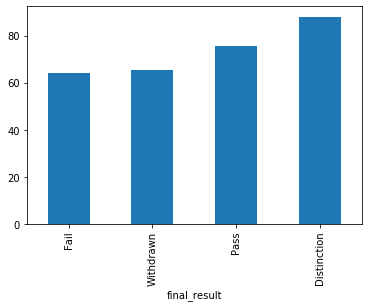

In [129]:
df.groupby('final_result').score.mean().sort_values().plot(kind='bar',);

### What this shows us:
It looks as though the number of clicks above 700 isn't that predictive, but below 700 could be. Particularly of withdrawal and failure. There also seems to be a link between final_result and number of clicks

### Next question: Let's look just at those people/modules that have less than 700 clicks, and see if it's more predictive

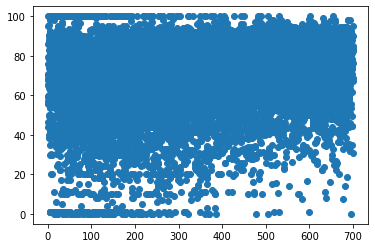

In [130]:
plt.scatter((df.sum_click[df.sum_click < 700]),(df.score[df.sum_click < 700]))

## Overall conclusion so far
We have seen that number there is a relationship between number of clicks and final result, and particularly that it might be possible at the lower end of engagement to predict withdrawal or failure from VLE engagement. However our independent variables by themselves don't seem to be predictive of mean assessment score.  

Let's continue anyway, to see if we get any results from a multiple linear regression

In [131]:
#Let's check the datatypes
df.dtypes

code_module             category
code_presentation       category
id_student                 int64
gender                  category
region                  category
highest_education       category
imd_band                category
age_band                category
num_of_prev_attempts       int64
studied_credits         category
disability              category
final_result            category
score                    float64
sum_click                float64
dtype: object

In [132]:
df.isnull().sum()
df.dropna(inplace=True)

In [133]:
df.describe()

id_student  num_of_prev_attempts         score     sum_click
count  3.013300e+04          30133.000000  30133.000000  30133.000000
mean   7.058065e+05              0.150931     72.475811   1558.836492
std    5.462933e+05              0.456801     16.855059   1791.296185
min    6.516000e+03              0.000000      0.000000      1.000000
25%    5.101860e+05              0.000000     64.000000    416.000000
50%    5.902150e+05              0.000000     76.000000    957.000000
75%    6.373470e+05              0.000000     84.666667   2046.000000
max    2.698588e+06              6.000000    100.000000  24139.000000

So num_of_prev_attempts is heavily positively skewed. studied_credits might have significant outliers. There is a large variation in sum_click, with std larger than mean. 

In [134]:
df_target = df.score
df.drop(['score'],axis=1,inplace=True)
df.drop(['id_student'],axis=1,inplace=True)

Check for multicollinearity

In [135]:
df.head()
df.dtypes

code_module             category
code_presentation       category
gender                  category
region                  category
highest_education       category
imd_band                category
age_band                category
num_of_prev_attempts       int64
studied_credits         category
disability              category
final_result            category
sum_click                float64
dtype: object

In [136]:
#Check multicollinearity
corr = df.corr()
corr

num_of_prev_attempts  sum_click
num_of_prev_attempts              1.000000  -0.033929
sum_click                        -0.033929   1.000000

There is no significant multicollinearity between independent variables  

Next, let's normalise the continuous variables - num_of_prev_attempts, studied_credits,score,date, sum_clicks, plus the target variable score

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120d6d6a0>,
      dtype=object)

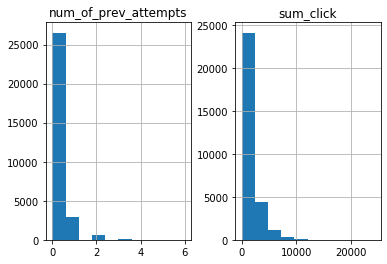

In [137]:
df.hist()

### Scaling the continuous features

In [138]:
df.num_of_prev_attempts = (df.num_of_prev_attempts - df.num_of_prev_attempts.mean())/df.num_of_prev_attempts.std()
df.sum_click = (df.sum_click - df.sum_click.mean())/df.sum_click.std()
df_target = (df_target - df_target.mean())/df_target.std()

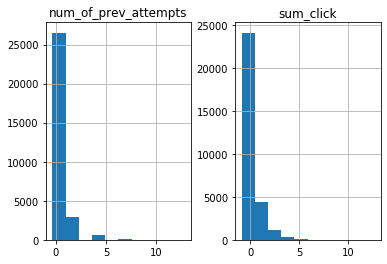

In [139]:
df.hist();

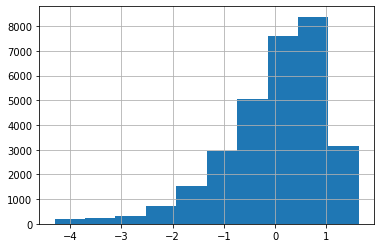

In [140]:
df_target.hist();

### How normal are these independent variables?

In [141]:
#test skew and kurtosis
print("Kurtosis",df.kurtosis(axis=0))
print("Skew",df.skew(axis=0))
print("Target Kurtosis",df_target.kurtosis(axis=0))
print("Target Skew",df_target.skew(axis=0))


Kurtosis num_of_prev_attempts    20.168328
sum_click               14.620519
dtype: float64
Skew num_of_prev_attempts    3.880055
sum_click               2.924741
dtype: float64
Target Kurtosis 2.2216777806993075
Target Skew -1.262121844298866


All variables have positive skewness and kurtosis nowhere near zero. However we can't log transform with the data we have, as there are lots of invalid values including 0s. 

### Perform standard transformation on the variables

In [142]:
df.num_of_prev_attempts.value_counts()

-0.330408     26515
 1.858728      2897
 4.047863       568
 6.236999       112
 8.426135        29
 10.615270        9
 12.804406        3
Name: num_of_prev_attempts, dtype: int64

In [149]:
df_target.shape

(30133,)

In [151]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_trans = df
df_trans.head()
df_trans['num_of_prev_attempts'] = scaler.fit_transform(df[['num_of_prev_attempts','sum_click']])
df_trans_target = scaler.fit_transform(pd.DataFrame(df_target))

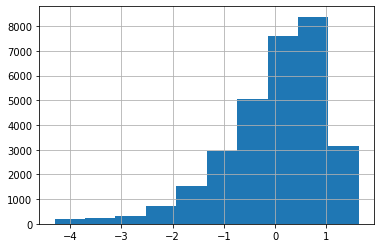

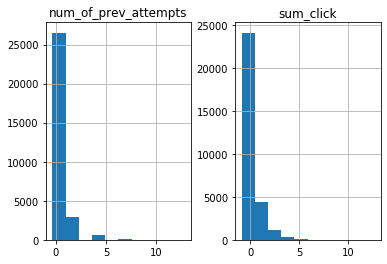

In [152]:
df_target.hist();
df_trans.hist();

# Modelling

## One hot encoding

In [153]:
df_trans = pd.get_dummies(df_trans)
df_trans.shape
df_trans.dtypes
for i in df_trans.columns[2:]:
    df_trans[i] = df_trans[i].astype('category')

In [154]:
df_trans.dtypes
df_trans['score']=df_target

## Check for Linearity between each independent variable and the target variable

(30133, 66)

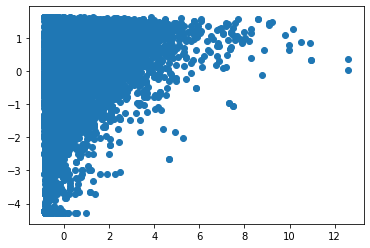

In [155]:
plt.scatter(df_trans['sum_click'],df_target)
df_trans.sum_click.isnull().sum()
df_trans.shape

In [156]:
#replace spaces in strings with _ for modelling purposes
df_trans.columns = df_trans.columns.str.replace(' ', '_')
df_trans.columns = df_trans.columns.str.replace('-', '_')
df_trans.columns = df_trans.columns.str.replace('%', '')
df_trans.columns = df_trans.columns.str.replace('?', '')
df_trans.columns = df_trans.columns.str.replace('<', '')
df_trans.columns = df_trans.columns.str.replace('=', '')
df_trans.columns = df_trans.columns.str.replace(']', ')')
df_trans.columns = df_trans.columns.str.replace('(', '')
df_trans.columns = df_trans.columns.str.replace(')', '')
df_trans.columns = df_trans.columns.str.replace(',', '')

df_trans.head()

num_of_prev_attempts  sum_click code_module_AAA code_module_BBB  \
0             -0.330414  -0.348818               1               0   
1             -0.330414  -0.069132               1               0   
2             -0.330414   0.334486               1               0   
3             -0.330414  -0.292993               1               0   
4             -0.330414   0.494705               1               0   

  code_module_CCC code_module_DDD code_module_EEE code_module_FFF  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

  code_module_GGG code_presentation_2013B  ... studied_credits_450_500  \
0               0                       0  ...                       0   
1               0                       0  ...                       0   
2               0                       0  ...                       0   
3               0                       0  ...                       0   
4               0                       0  ...                       0   

  studied_credits_500_550 studied_credits_550_600 disability_N disability_Y  \
0                       0                       0            1            0   
1                       0                       0            1            0   
2                       0                       0            1            0   
3                       0                       0            1            0   
4                       0                       0            1            0   

  final_result_Distinction final_result_Fail final_result_Pass  \
0                        0                 0                 1   
1                        0                 0                 1   
2                        0                 0                 1   
3                        0                 0                 1   
4                        0                 0                 1   

  final_result_Withdrawn     score  
0                      0  0.565064  
1                      0 -0.360474  
2                      0  0.209088  
3                      0 -1.072426  
4                      0 -0.265547  

[5 rows x 66 columns]

## Let's look at linear regression by variable

In [157]:
import statsmodels.formula.api as smf

dfcol = ['num_of_prev_attempts','sum_click']
result = []
for count, i in enumerate(dfcol):
    formula = 'score ~' + ' ' + i
    model = smf.ols(formula, data = df_trans).fit()
    #print(model.params[0],model.params[1],model.pvalues[1])
    result.append([i, model.rsquared, model.params[0],model.params[1],model.pvalues[1]]);
    print(f'''Result for {i}:
    R_squared: {model.rsquared}
    P_value: {model.pvalues}''')

Result for num_of_prev_attempts:
    R_squared: 0.005871183546224956
    P_value: Intercept               1.000000e+00
num_of_prev_attempts    1.770496e-40
dtype: float64
Result for sum_click:
    R_squared: 0.07018164270858851
    P_value: Intercept    1.0
sum_click    0.0
dtype: float64


So not great. Let's try the categorical variables

In [158]:
df_trans.columns

Index(['num_of_prev_attempts', 'sum_click', 'code_module_AAA',
       'code_module_BBB', 'code_module_CCC', 'code_module_DDD',
       'code_module_EEE', 'code_module_FFF', 'code_module_GGG',
       'code_presentation_2013B', 'code_presentation_2013J',
       'code_presentation_2014B', 'code_presentation_2014J', 'gender_F',
       'gender_M', 'region_East_Anglian_Region', 'region_East_Midlands_Region',
       'region_Ireland', 'region_London_Region', 'region_North_Region',
       'region_North_Western_Region', 'region_Scotland',
       'region_South_East_Region', 'region_South_Region',
       'region_South_West_Region', 'region_Wales',
       'region_West_Midlands_Region', 'region_Yorkshire_Region',
       'highest_education_A_Level_or_Equivalent',
       'highest_education_HE_Qualification',
       'highest_education_Lower_Than_A_Level',
       'highest_education_No_Formal_quals',
       'highest_education_Post_Graduate_Qualification', 'imd_band_0_10',
       'imd_band_10_20', 'imd_ban

In [159]:
cols_module= df_trans.columns[2:9]
cols_pres= df_trans.columns[9:13]
cols_gender = df_trans.columns[13:15]
cols_region = df_trans.columns[13:28]
cols_ed = df_trans.columns[28:33]
cols_imd = df_trans.columns[33:44]
cols_age = df_trans.columns[44:47]
cols_cred = df_trans.columns[47:59]
cols_dis = df_trans.columns[59:61]
cols_result = df_trans.columns[61:65]

print(cols_result)


Index(['final_result_Distinction', 'final_result_Fail', 'final_result_Pass',
       'final_result_Withdrawn'],
      dtype='object')


In [160]:
cols = [cols_module, cols_pres , cols_gender, cols_region,cols_ed,cols_imd,cols_age,cols_cred,cols_dis,cols_result]
for col in cols:
    sum_cols = "+".join(col)
    form = "score ~" + sum_cols
    model = smf.ols(formula= form, data= df_trans).fit()
    #model = smf.ols(formula, data = df).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     145.8
Date:                Tue, 12 May 2020   Prob (F-statistic):          1.86e-212
Time:                        11:56:17   Log-Likelihood:                -42254.
No. Observations:               30133   AIC:                         8.452e+04
Df Residuals:                   30125   BIC:                         8.459e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -5.75e+09 

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     100.7
Date:                Tue, 12 May 2020   Prob (F-statistic):          1.18e-105
Time:                        11:56:18   Log-Likelihood:                -42507.
No. Observations:               30133   AIC:                         8.503e+04
Df Residuals:                   30127   BIC:                         8.508e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

Let's drop some of the less predictive columns, and one from each category

In [161]:
df_final = df_trans.drop(["num_of_prev_attempts","code_module_AAA","code_presentation_2013B","gender_F","region_East_Anglian_Region","highest_education_No_Formal_quals","imd_band_0_10","studied_credits_550_600","disability_Y","final_result_Fail"], axis=1)
y = df_final[["score"]]
X = df_final.drop(["score"], axis=1)

In [162]:
df_final.shape

(30133, 56)

## Feature selection
We will use recursive feature selection to find the best combination of features. 

In [164]:
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


r_list = []
adj_r_list = []
list_n = list(range(1,56,2))
for n in list_n: 
    linreg = LinearRegression()
    select_n = RFE(linreg, n_features_to_select = n)
    select_n = select_n.fit(X, np.ravel(y))
    selected_columns = X.columns[select_n.support_ ]
    linreg.fit(X[selected_columns],y)
    yhat = linreg.predict(X[selected_columns])
    SS_Residual = np.sum((y-yhat)**2)
    SS_Total = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    print(selected_columns)
    print(r_squared)
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    print(adjusted_r_squared)
r_list.append(r_squared)
adj_r_list.append(adjusted_r_squared)

#Here we are printing the adjusted R Squared for each regression. 

Index(['final_result_Distinction'], dtype='object')
score    0.112767
dtype: float64
score    0.111144
dtype: float64
Index(['studied_credits_350_400', 'final_result_Distinction',
       'final_result_Pass'],
      dtype='object')
score    0.200315
dtype: float64
score    0.198852
dtype: float64
Index(['highest_education_Post_Graduate_Qualification',
       'studied_credits_350_400', 'studied_credits_400_450',
       'final_result_Distinction', 'final_result_Pass'],
      dtype='object')
score    0.201818
dtype: float64
score    0.200358
dtype: float64
Index(['highest_education_A_Level_or_Equivalent',
       'highest_education_HE_Qualification',
       'highest_education_Post_Graduate_Qualification',
       'studied_credits_350_400', 'studied_credits_400_450',
       'final_result_Distinction', 'final_result_Pass'],
      dtype='object')
score    0.203809
dtype: float64
score    0.202353
dtype: float64
Index(['code_module_GGG', 'highest_education_A_Level_or_Equivalent',
       'highest

Index(['sum_click', 'code_module_BBB', 'code_module_CCC', 'code_module_DDD',
       'code_module_EEE', 'code_module_FFF', 'code_module_GGG',
       'region_Scotland', 'highest_education_A_Level_or_Equivalent',
       'highest_education_HE_Qualification',
       'highest_education_Lower_Than_A_Level',
       'highest_education_Post_Graduate_Qualification', 'imd_band_30_40',
       'imd_band_40_50', 'imd_band_50_60', 'imd_band_60_70', 'imd_band_70_80',
       'imd_band_80_90', 'imd_band_90_100', 'imd_band_', 'age_band_55',
       'studied_credits_0_50', 'studied_credits_50_100',
       'studied_credits_100_150', 'studied_credits_150_200',
       'studied_credits_200_250', 'studied_credits_300_350',
       'studied_credits_350_400', 'studied_credits_400_450', 'disability_N',
       'final_result_Distinction', 'final_result_Pass',
       'final_result_Withdrawn'],
      dtype='object')
score    0.243179
dtype: float64
score    0.241795
dtype: float64
Index(['sum_click', 'code_module_BBB', 

Index(['sum_click', 'code_module_BBB', 'code_module_CCC', 'code_module_DDD',
       'code_module_EEE', 'code_module_FFF', 'code_module_GGG',
       'code_presentation_2013J', 'code_presentation_2014B',
       'code_presentation_2014J', 'gender_M', 'region_Ireland',
       'region_London_Region', 'region_North_Region',
       'region_North_Western_Region', 'region_Scotland',
       'region_South_East_Region', 'region_South_West_Region',
       'region_West_Midlands_Region', 'region_Yorkshire_Region',
       'highest_education_A_Level_or_Equivalent',
       'highest_education_HE_Qualification',
       'highest_education_Lower_Than_A_Level',
       'highest_education_Post_Graduate_Qualification', 'imd_band_20_30',
       'imd_band_30_40', 'imd_band_40_50', 'imd_band_50_60', 'imd_band_60_70',
       'imd_band_70_80', 'imd_band_80_90', 'imd_band_90_100', 'imd_band_',
       'age_band_0_35', 'age_band_35_55', 'age_band_55',
       'studied_credits_0_50', 'studied_credits_50_100',
       'stu

## Conclusion:
The highest adjusted R_squared is 0.244215 which means that 25% of the variance can be explained by the model. This clearly isn't good enough to be used by itself. However we could look further into the relationship between final score and vle engagement. We might also wish to employ random forests in order to increase R_squared. 